# Import libraries

In [122]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import lightgbm
np.random.seed(42)
random_state = 42
random.seed(42)

# Load data

In [7]:
train_data = pd.read_csv('data/train.csv', dayfirst=False, date_parser='report_date')
train_data.head()

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_38980/2044319017.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  train_data = pd.read_csv('data/train.csv', dayfirst=False, date_parser='report_date')


,month_churn,nid,report_date,v_0,v_1,v_10,v_100,v_101,v_102,v_103,...,v_91,v_92,v_93,v_94,v_95,v_96,v_97,v_98,v_99,week_churn
0,0,10363,2024-09-08,45,48,344,7,5,5,0,...,0,0,45,48,0,3,7,7,6,0
1,0,3303,2024-10-27,35,42,47,45,43,45,0,...,0,1,46,275,1,1,47,47,45,1
2,0,9732,2023-10-29,35,39,19,19,6,6,0,...,0,0,45,76,1,0,19,19,19,1
3,1,2934,2024-12-08,11,15,101,91,31,48,0,...,0,1,122,460,0,0,93,93,84,1
4,0,3251,2024-03-10,3,3,181,33,23,23,0,...,0,0,29,73,1,2,33,33,32,0


In [89]:
test_data = pd.read_csv('data/test.csv', dayfirst=False, date_parser='report_date')
test_data.head()

/var/folders/_2/3r2pyzk16rdbwgbf6s6rlngr0000gn/T/ipykernel_38980/3519892073.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  test_data = pd.read_csv('data/test.csv', dayfirst=False, date_parser='report_date')


,nid,report_date,v_0,v_1,v_10,v_100,v_101,v_102,v_103,v_104,...,v_90,v_91,v_92,v_93,v_94,v_95,v_96,v_97,v_98,v_99
0,2378,2023-11-26,109,155,142,142,97,122,0,0,...,1060,0,0,155,1012,2,3,142,142,136
1,4004,2024-05-19,17,28,62,60,6,24,0,0,...,216,0,2,44,194,0,0,62,62,49
2,9151,2024-02-25,44,63,64,64,59,62,0,0,...,78,0,0,48,73,18,18,64,64,62
3,6701,2023-10-29,27,41,37,37,16,19,0,0,...,166,0,0,32,138,0,0,37,37,30
4,10771,2023-12-03,43,77,341,218,102,158,0,0,...,451,0,0,58,417,8,9,219,219,194


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248180 entries, 0 to 248179
Columns: 279 entries, month_churn to week_churn
dtypes: int64(278), object(1)
memory usage: 528.3+ MB


In [6]:
train_data.columns

Index(['month_churn', 'nid', 'report_date', 'v_0', 'v_1', 'v_10', 'v_100',
       'v_101', 'v_102', 'v_103',
       ...
       'v_91', 'v_92', 'v_93', 'v_94', 'v_95', 'v_96', 'v_97', 'v_98', 'v_99',
       'week_churn'],
      dtype='object', length=279)

In [105]:
train_data['report_date'] = pd.to_datetime(train_data['report_date'])
test_data['report_date'] = pd.to_datetime(test_data['report_date'])

In [74]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248180 entries, 0 to 248179
Columns: 279 entries, month_churn to week_churn
dtypes: datetime64[ns](1), int64(278)
memory usage: 528.3 MB


# EDA & FE

In [289]:
def extract_datetime_features(df, column):
    output = df.copy()
    output['year'] = output[column].dt.year
    output['month'] = output[column].dt.quarter
    output['month'] = output[column].dt.month
    output['week'] = output[column].dt.isocalendar().week
    output['day'] = output[column].dt.day
    output['day_of_week'] = output[column].dt.dayofweek
    output['is_weekend'] = output[column].dt.dayofweek > 5

    return output 
    

In [292]:
def cossin_datetime_features(df):
    output = df.copy()
    
    output['quarter_sin'] = np.sin(2 * np.pi * (output['quarter'] - 1) / 12)
    output['quarter_sin'] = np.sin(2 * np.pi * (output['quarter'] - 1) / 12)
    
    output['month_sin'] = np.sin(2 * np.pi * (output['month'] - 1) / 12)
    output['month_cos'] = np.cos(2 * np.pi * (output['month'] - 1) / 12)

    output['week_sin'] = np.sin(2 * np.pi * (output['week'] - 1) / 12)
    output['week_cos'] = np.cos(2 * np.pi * (output['week'] - 1) / 12)
    
    output['day_sin'] = np.sin(2 * np.pi * (output['day'] - 1) / 12)
    output['day_cos'] = np.cos(2 * np.pi * (output['day'] - 1) / 12)
    
    output['day_of_week_sin'] = np.sin(2 * np.pi * (output['day_of_week'] - 1) / 12)
    output['day_of_week_cos'] = np.cos(2 * np.pi * (output['day_of_week'] - 1) / 12)

    return output

In [202]:
train_featured_data = extract_datetime_features(train_data, 'report_date')
train_featured_data['is_weekend'] = train_featured_data['is_weekend'].astype(int)
train_featured_data = cossin_datetime_features(train_featured_data)

In [203]:
monthly_churn = train_featured_data.groupby('month')['month_churn'].mean().reset_index().rename(columns={'month_churn': 'month_proba'})
monthly_churn

,month,month_proba
0,1,0.072268
1,2,0.104718
2,3,0.111042
3,4,0.142930
4,5,1.000000
5,9,0.064227
6,10,0.100892
7,11,0.099533
8,12,0.135431


In [204]:
weekly_churn = train_featured_data.groupby('week')['week_churn'].mean().reset_index().rename(columns={'week_churn': 'week_proba'})
weekly_churn

,week,week_proba
0,1,0.570554
1,2,0.088859
2,3,0.106406
3,4,0.127710
4,5,0.175643
5,6,0.158753
6,7,0.237854
7,8,0.131707
8,9,0.249276
9,10,0.122340


In [205]:
train_featured_data = train_featured_data.merge(monthly_churn, on='month', how='left')
train_featured_data = train_featured_data.merge(weekly_churn, on='week', how='left')

In [206]:
train_featured_data.columns

Index(['month_churn', 'nid', 'report_date', 'v_0', 'v_1', 'v_10', 'v_100',
       'v_101', 'v_102', 'v_103',
       ...
       'month_sin', 'month_cos', 'week_sin', 'week_cos', 'day_sin', 'day_cos',
       'day_of_week_sin', 'day_of_week_cos', 'month_proba', 'week_proba'],
      dtype='object', length=295)

In [40]:
grouped_by_month_train = train_featured_data.groupby(['nid', 'year', 'month'])[['month_churn', 'week_churn']].agg('sum')
grouped_by_month_train

month_churn  week_churn
nid   year month                         
1     2024 10               0           2
           11               0           1
           12               0           2
      2025 1                0           2
           2                0           1
...                       ...         ...
11734 2025 3                0           0
11735 2023 12               0           2
      2024 1                0           0
           2                0           2
           3                2           2

[72073 rows x 2 columns]

In [59]:
train_featured_data.groupby(['nid'])['report_date'].agg('count').describe()

count    11703.000000
mean        21.206528
std         20.435704
min          1.000000
25%          4.000000
50%         14.000000
75%         31.000000
max         79.000000
Name: report_date, dtype: float64

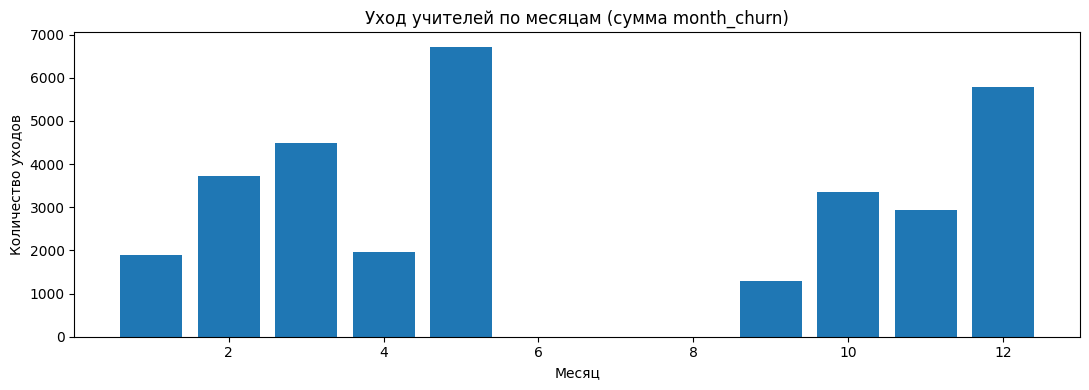

In [81]:
monthly = (train_featured_data
           .groupby(['month'])['month_churn']
           .sum()
           .rename('month_churn_sum')
          )

months_ru = ['Янв','Фев','Мар','Апр','Май','Июн','Июл','Авг','Сен','Окт','Ноя','Дек']

plt.figure(figsize=(11,4))
plt.bar(monthly.index, monthly.values)
plt.title('Уход учителей по месяцам (сумма month_churn)')
plt.ylabel('Количество уходов')
plt.xlabel('Месяц')
plt.tight_layout()
plt.show()


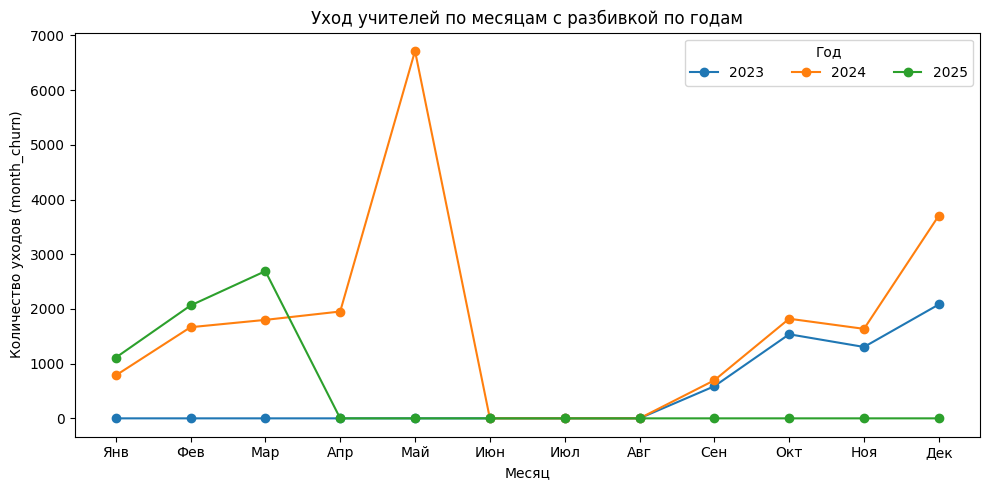

In [84]:
# Пивот: строки — месяцы (1..12), столбцы — года
month_year = (train_featured_data
              .groupby(['year','month'])['month_churn']
              .sum()
              .reset_index())

# Полная сетка 12 месяцев на каждый год (заполним нулями, если какие-то месяцы отсутствуют)
all_years = sorted(month_year['year'].unique())
full = (pd.MultiIndex.from_product([all_years, range(1,13)], names=['year','month'])
        .to_frame(index=False)
        .merge(month_year, on=['year','month'], how='left')
        .fillna({'month_churn': 0})
       )

pivot = full.pivot(index='month', columns='year', values='month_churn').sort_index()
pivot.index.name = 'Месяц'

plt.figure(figsize=(10,5))
for y in pivot.columns:
    plt.plot(pivot.index, pivot[y], label=str(y), marker='o')

plt.title('Уход учителей по месяцам с разбивкой по годам')
plt.xlabel('Месяц')
plt.ylabel('Количество уходов (month_churn)')
plt.xticks(ticks=range(1,13), labels=months_ru)
plt.legend(title='Год', ncol=min(4, len(pivot.columns)))
plt.tight_layout()
plt.show()


In [97]:
train_featured_data['test'] = 0
train_featured_data.tail()

,month_churn,nid,report_date,v_0,v_1,v_10,v_100,v_101,v_102,v_103,...,v_98,v_99,week_churn,year,month,week,day,day_of_week,is_weekend,test
248175,0,7535,2024-09-22,49,99,1192,105,49,59,0,...,106,87,0,2024,9,38,22,6,True,0
248176,0,7539,2023-10-15,34,34,67,56,32,38,0,...,67,41,0,2023,10,41,15,6,True,0
248177,0,7919,2024-11-24,59,96,41,39,29,35,0,...,41,38,0,2024,11,47,24,6,True,0
248178,1,10803,2023-09-24,4,4,0,0,0,0,0,...,0,0,1,2023,9,38,24,6,True,0
248179,0,5945,2024-04-28,3,3,354,66,6,16,0,...,68,47,0,2024,4,17,28,6,True,0


In [106]:
test_copy = test_data.copy()
test_copy['test'] = 1

In [107]:
merged = pd.concat([train_featured_data, test_copy])
merged.tail()

,month_churn,nid,report_date,v_0,v_1,v_10,v_100,v_101,v_102,v_103,...,v_98,v_99,week_churn,year,month,week,day,day_of_week,is_weekend,test
27432,NaN,10597,2024-02-18,15,19,58,52,5,6,0,...,58,41,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,1
27433,NaN,8737,2024-11-10,16,52,38,37,8,6,0,...,38,34,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,1
27434,NaN,2881,2024-10-13,28,28,48,8,4,6,0,...,10,5,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,1
27435,NaN,11067,2024-04-28,18,18,11,11,0,0,0,...,11,8,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,1
27436,NaN,549,2024-05-19,94,138,358,90,56,72,0,...,91,89,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,1


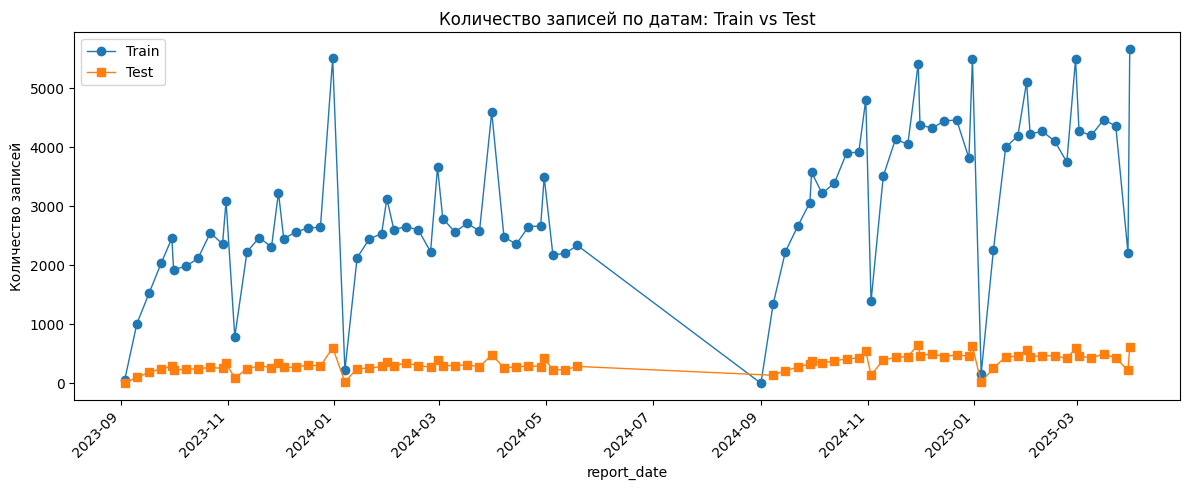

In [110]:
train_counts = (merged.loc[merged['test'] == 0]
                  .groupby('report_date')
                  .size()
                  .sort_index())

test_counts = (merged.loc[merged['test'] == 1]
                 .groupby('report_date')
                 .size()
                 .sort_index())

# график
plt.figure(figsize=(12,5))
plt.plot(train_counts.index, train_counts.values, marker='o', linewidth=1, label='Train')
plt.plot(test_counts.index,  test_counts.values,  marker='s', linewidth=1, label='Test')
plt.title('Количество записей по датам: Train vs Test')
plt.xlabel('report_date')
plt.ylabel('Количество записей')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()


## Class balance

In [60]:
train_featured_data['month_churn'].value_counts(normalize=True)

month_churn
0    0.870445
1    0.129555
Name: proportion, dtype: float64

In [64]:
train_featured_data['week_churn'].value_counts(normalize=True)

week_churn
0    0.751181
1    0.248819
Name: proportion, dtype: float64

In [67]:
weights_week = (1 - train_featured_data['week_churn'].value_counts(normalize=True)).to_dict()
weights_month = (1 - train_featured_data['month_churn'].value_counts(normalize=True)).to_dict()

# Train/Test

In [229]:
X = train_featured_data.drop(columns=['report_date', 'month', 'day', 'day_of_week', 'year', 'week', 'month_churn', 'week_churn'])
y = train_featured_data[['month_churn', 'week_churn']]
X['nid'] = X['nid'].astype('category')

In [280]:
lgbm_month_cls = lightgbm.LGBMClassifier(learning_rate=0.35, num_leaves=100, n_estimators=2000, class_weight=weights_month, random_state=42)
lgbm_month_cls.fit(X, y['month_churn'])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 32153, number of negative: 216027
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051803 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61962
[LightGBM] [Info] Number of data points in the train set: 248180, number of used features: 283
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

,boosting_type,'gbdt'
,num_leaves,100
,max_depth,-1
,learning_rate,0.35
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,"{0: 0.12955516157627534, 1: 0.8704448384237247}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [284]:
lgbm_week_cls = lightgbm.LGBMClassifier(learning_rate=0.35, num_leaves=100, n_estimators=2000, class_weight=weights_week, random_state=42)
lgbm_week_cls.fit(X, y['week_churn'])

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 61752, number of negative: 186428
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.054474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 61962
[LightGBM] [Info] Number of data points in the train set: 248180, number of used features: 283
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


,boosting_type,'gbdt'
,num_leaves,100
,max_depth,-1
,learning_rate,0.35
,n_estimators,2000
,subsample_for_bin,200000
,objective,None
,class_weight,"{0: 0.24881940527036828, 1: 0.7511805947296317}"
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


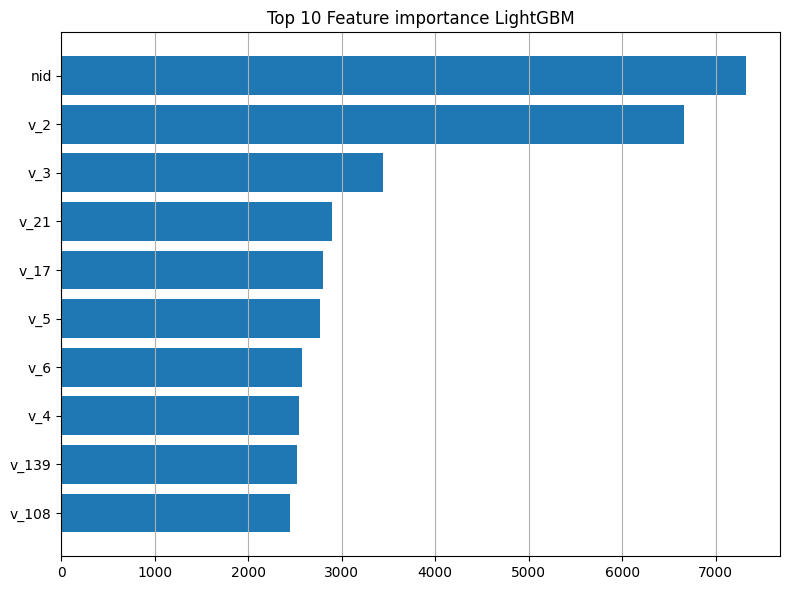

In [287]:
importances = lgbm_month_cls.feature_importances_
feature_names = lgbm_month_cls.feature_names_in_

sorted_idx = importances.argsort()[::-1]

top_n = 10
top_idx = sorted_idx[:top_n]

plt.figure(figsize=(8,6))
plt.barh(feature_names[top_idx], importances[top_idx])
plt.grid(axis='x')
plt.title('Top 10 Feature importance LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

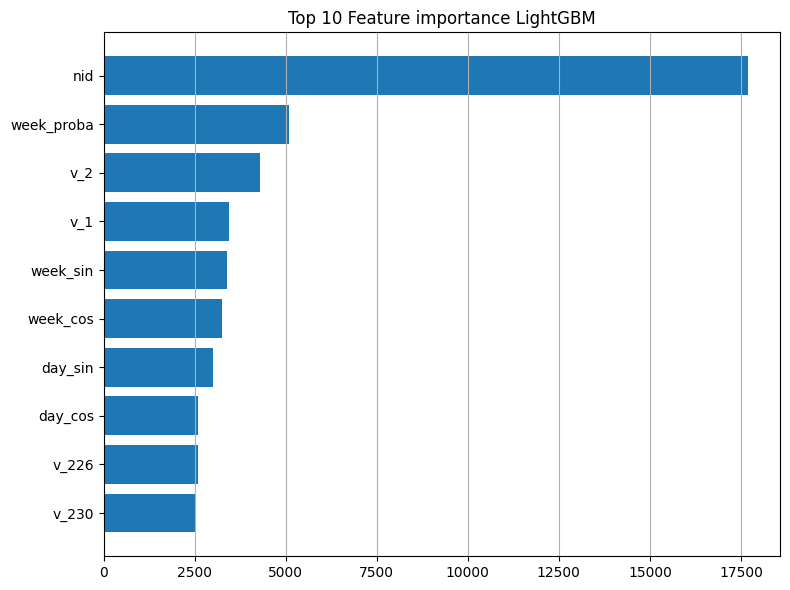

In [288]:
importances = lgbm_week_cls.feature_importances_
feature_names = lgbm_week_cls.feature_names_in_

sorted_idx = importances.argsort()[::-1]

top_n = 10
top_idx = sorted_idx[:top_n]

plt.figure(figsize=(8,6))
plt.barh(feature_names[top_idx], importances[top_idx])
plt.grid(axis='x')
plt.title('Top 10 Feature importance LightGBM')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save result

In [282]:
featured_test = cossin_datetime_features(extract_datetime_features(test_data, 'report_date'))
featured_test = featured_test.merge(monthly_churn, on='month', how='left')
featured_test = featured_test.merge(weekly_churn, on='week', how='left')
featured_test.drop(columns=['report_date', 'month', 'day', 'day_of_week', 'year', 'week'], inplace=True)
featured_test['nid'] = featured_test['nid'].astype('category')

In [285]:
month_pred = lgbm_month_cls.predict_proba(featured_test)
week_pred = lgbm_week_cls.predict_proba(featured_test)

In [286]:
submission = pd.DataFrame(data={'nid':test_data['nid'], 'month_churn':month_pred[:,1], 'week_churn': week_pred[:,1]})
submission.to_csv('submission.csv')